In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from numpy import array
from datetime import datetime
import seaborn as sns

2022-10-19 01:38:25.291428: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-19 01:38:25.291464: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
sns.set_style("darkgrid")
cm = 1/2.54 
colors = ['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377', '#BBBBBB']
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

### Replace missing values with Zero and Group by month

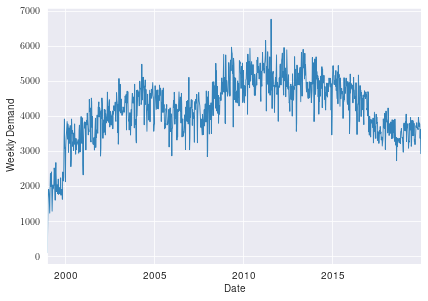

In [3]:
df= pd.read_csv('consumos.csv', parse_dates=['date'])
df['nr'].fillna(value=0, inplace=True)
df=df.groupby('date').sum()
df=df.resample(rule='W').sum()
df = df.iloc[:-1 , :]
dataset = df.values
dataset = df.astype('float32')
df.plot(figsize=(17*cm,12*cm), legend=None, linewidth=0.9, alpha=0.9)
plt.ylabel('Weekly Demand')
plt.xlabel('Date')
plt.savefig('figures/demand_weekly.pdf')

### Create batches of training data (12 months)

In [4]:
def split_sequence(sequence, n_steps_in, n_steps_out, slide):
    X, y = list(), list()
    for i in range(0, len(sequence), slide):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

### Define and fit LSTM model 

In [5]:
def fit(X, y, n_steps_in, n_steps_out):
    callback = EarlyStopping(monitor='loss', patience=100)
    model = Sequential()
    model.add(LSTM(units=50, activation='relu', input_shape=(n_steps_in, 1)))
    model.add(Dense(n_steps_out))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=500, callbacks=[callback])
    return model 

In [6]:
def train_predict(dataset, test, actual):
    n_steps_in, n_steps_out, slide = 24, 8, 1
    X, y = split_sequence(dataset, n_steps_in, n_steps_out, slide)
    
    model = fit(X, y, n_steps_in, n_steps_out)
    
    mae, rmse, smape = list(), list(), list()
    for i in range(0, len(test)-n_steps_in, n_steps_out):
        x_input = array(test[i:n_steps_in+i])
        x_input = x_input.reshape((1, n_steps_in, 1))
        pred = model.predict(x_input).reshape(-1, 1)
        pred = scaler.inverse_transform(pred)
        mae_aux, rmse_aux, smape_aux = measure_error(actual, pred, n_steps_in, n_steps_out, i)
        mae.append(mae_aux), rmse.append(rmse_aux), smape.append(smape_aux)
    
    return mae, rmse, smape

In [7]:
def sMAPE(actual, predicted):
    if not all([isinstance(actual, np.ndarray), 
                isinstance(predicted, np.ndarray)]):
        actual, predicted = np.array(actual),
        np.array(predicted)
    return round(np.mean(np.abs(predicted - actual) / ((np.abs(predicted) + np.abs(actual))/2))*100, 2)

In [8]:
def measure_error(actual, pred, step_in, step_out, index):
    print(actual[index+step_in:index+step_in+step_out],pred,index+step_in,index+step_in+step_out)
    mae = mean_absolute_error(actual[index+step_in:index+step_in+step_out], pred)
    rmse = np.sqrt(mean_squared_error(actual[index+step_in:index+step_in+step_out], pred))
    smape = sMAPE(actual[index+step_in:index+step_in+step_out], pred)
    return mae, rmse, smape

### Normalize Data Set and Split Train and Test

In [9]:
len(df)

1096

In [10]:
dataset = df.values
dataset = df.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train=dataset[:952] 
test=dataset[952:]  
mae, rmse, smape = train_predict(train, test, df[952:].values)

2022-10-19 01:38:28.728213: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-10-19 01:38:28.728291: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ubuntu): /proc/driver/nvidia/version does not exist
2022-10-19 01:38:28.728806: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/500
29/29 [==============================] - 3s 19ms/step - loss: 0.3180
Epoch 2/500
29/29 [==============================] - 1s 22ms/step - loss: 0.0533
Epoch 3/500
29/29 [==============================] - 1s 23ms/step - loss: 0.0063
Epoch 4/500
29/29 [==============================] - 1s 25ms/step - loss: 0.0052
Epoch 5/500
29/29 [==============================] - 1s 25ms/step - loss: 0.0051
Epoch 6/500
29/29 [==============================] - 1s 24ms/step - loss: 0.0050
Epoch 7/500
29/29 [==============================] - 1s 26ms/step - loss: 0.0050
Epoch 8/500
29/29 [==============================] - 1s 24ms/step - loss: 0.0050
Epoch 9/500
29/29 [==============================] - 1s 24ms/step - loss: 0.0051
Epoch 10/500
29/29 [==============================] - 1s 25ms/step - loss: 0.0050
Epoch 11/500
29/29 [==============================] - 1s 28ms/step - loss: 0.0049
Epoch 12/500
29/29 [==============================] - 1s 28ms/step - loss: 0.0049
Epoch 13/500
29/29 [=====

29/29 [==============================] - 1s 20ms/step - loss: 0.0048
Epoch 102/500
29/29 [==============================] - 1s 20ms/step - loss: 0.0048
Epoch 103/500
29/29 [==============================] - 0s 17ms/step - loss: 0.0048
Epoch 104/500
29/29 [==============================] - 1s 21ms/step - loss: 0.0048
Epoch 105/500
29/29 [==============================] - 1s 22ms/step - loss: 0.0048
Epoch 106/500
29/29 [==============================] - 1s 20ms/step - loss: 0.0049
Epoch 107/500
29/29 [==============================] - 1s 17ms/step - loss: 0.0049
Epoch 108/500
29/29 [==============================] - 1s 21ms/step - loss: 0.0048
Epoch 109/500
29/29 [==============================] - 1s 19ms/step - loss: 0.0049
Epoch 110/500
29/29 [==============================] - 1s 19ms/step - loss: 0.0049
Epoch 111/500
29/29 [==============================] - 1s 21ms/step - loss: 0.0049
Epoch 112/500
29/29 [==============================] - 1s 20ms/step - loss: 0.0048
Epoch 113/500
29/2

29/29 [==============================] - 1s 28ms/step - loss: 0.0048
Epoch 200/500
29/29 [==============================] - 1s 20ms/step - loss: 0.0047
Epoch 201/500
29/29 [==============================] - 1s 19ms/step - loss: 0.0047
Epoch 202/500
29/29 [==============================] - 1s 19ms/step - loss: 0.0047
Epoch 203/500
29/29 [==============================] - 1s 19ms/step - loss: 0.0047
Epoch 204/500
29/29 [==============================] - 1s 19ms/step - loss: 0.0048
Epoch 205/500
29/29 [==============================] - 1s 17ms/step - loss: 0.0048
Epoch 206/500
29/29 [==============================] - 1s 21ms/step - loss: 0.0048
Epoch 207/500
29/29 [==============================] - 1s 18ms/step - loss: 0.0047
Epoch 208/500
29/29 [==============================] - 1s 20ms/step - loss: 0.0047
Epoch 209/500
29/29 [==============================] - 1s 24ms/step - loss: 0.0049
Epoch 210/500
29/29 [==============================] - 1s 25ms/step - loss: 0.0047
Epoch 211/500
29/2

29/29 [==============================] - 1s 24ms/step - loss: 0.0047
Epoch 298/500
29/29 [==============================] - 1s 17ms/step - loss: 0.0046
Epoch 299/500
29/29 [==============================] - 1s 21ms/step - loss: 0.0047
Epoch 300/500
29/29 [==============================] - 1s 20ms/step - loss: 0.0047
Epoch 301/500
29/29 [==============================] - 1s 19ms/step - loss: 0.0047
Epoch 302/500
29/29 [==============================] - 1s 28ms/step - loss: 0.0047
Epoch 303/500
29/29 [==============================] - 1s 19ms/step - loss: 0.0046
Epoch 304/500
29/29 [==============================] - 1s 20ms/step - loss: 0.0046
Epoch 305/500
29/29 [==============================] - 1s 17ms/step - loss: 0.0046
Epoch 306/500
29/29 [==============================] - 0s 17ms/step - loss: 0.0047
Epoch 307/500
29/29 [==============================] - 1s 21ms/step - loss: 0.0046
Epoch 308/500
29/29 [==============================] - 1s 17ms/step - loss: 0.0046
Epoch 309/500
29/2

29/29 [==============================] - 1s 25ms/step - loss: 0.0046
Epoch 396/500
29/29 [==============================] - 1s 25ms/step - loss: 0.0046
Epoch 397/500
29/29 [==============================] - 1s 23ms/step - loss: 0.0047
Epoch 398/500
29/29 [==============================] - 1s 17ms/step - loss: 0.0046
Epoch 399/500
29/29 [==============================] - 1s 18ms/step - loss: 0.0046
Epoch 400/500
29/29 [==============================] - 0s 17ms/step - loss: 0.0046
Epoch 401/500
29/29 [==============================] - 1s 17ms/step - loss: 0.0046
Epoch 402/500
29/29 [==============================] - 1s 20ms/step - loss: 0.0046
Epoch 403/500
29/29 [==============================] - 1s 19ms/step - loss: 0.0046
Epoch 404/500
29/29 [==============================] - 1s 21ms/step - loss: 0.0046
Epoch 405/500
29/29 [==============================] - 1s 21ms/step - loss: 0.0046
Epoch 406/500
29/29 [==============================] - 1s 23ms/step - loss: 0.0046
Epoch 407/500
29/2

29/29 [==============================] - 1s 20ms/step - loss: 0.0045
Epoch 494/500
29/29 [==============================] - 1s 22ms/step - loss: 0.0045
Epoch 495/500
29/29 [==============================] - 1s 26ms/step - loss: 0.0045
Epoch 496/500
29/29 [==============================] - 1s 19ms/step - loss: 0.0045
Epoch 497/500
29/29 [==============================] - 1s 18ms/step - loss: 0.0045
Epoch 498/500
29/29 [==============================] - 0s 15ms/step - loss: 0.0045
Epoch 499/500
29/29 [==============================] - 1s 18ms/step - loss: 0.0045
Epoch 500/500
29/29 [==============================] - 1s 21ms/step - loss: 0.0045
[[3694]
 [3488]
 [3541]
 [3312]
 [3345]
 [3397]
 [3138]
 [3227]] [[3576.1729]
 [3675.273 ]
 [3688.807 ]
 [3687.3743]
 [3654.0686]
 [3657.564 ]
 [3648.558 ]
 [3743.645 ]] 24 32
[[3341]
 [3913]
 [3690]
 [3758]
 [3644]
 [4069]
 [3832]
 [3041]] [[3479.838 ]
 [3612.8816]
 [3641.546 ]
 [3644.3076]
 [3625.2974]
 [3632.8855]
 [3633.9958]
 [3728.4849]] 32 4

In [11]:
len(smape)

15

### Calculate Error

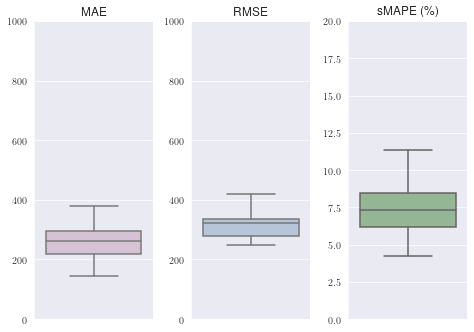

In [12]:
fig, axes = plt.subplots(1, 3, sharex=True, figsize=(17*cm,12*cm))
sns.boxplot(ax=axes[0], y=mae, color='thistle', showfliers=False)
axes[0].set_title('MAE')
axes[0].set(ylim=(0, 1000))
sns.boxplot(ax=axes[1], y=rmse, color='lightsteelblue', showfliers=False)
axes[1].set_title('RMSE')
axes[1].set(ylim=(0, 1000))
sns.boxplot(ax=axes[2], y=smape, color='darkseagreen', showfliers=False)
axes[2].set_title('sMAPE (\%)')
axes[2].set(ylim=(0, 20))
plt.tight_layout()
#plt.savefig('figures/demand_lstm_weekly_boxplot.pdf')

In [14]:
demand_lstm_week = [mae,rmse,smape]
%store demand_lstm_week

Stored 'demand_lstm_week' (list)
